### Blog Post: Replication Study - Dissecting racial bias an in algorithm used to manage the health of populations

In this blog post, I will

In [39]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

In [40]:
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


In [41]:
df_imp = df[["risk_score_t", "cost_t", "race", "gagne_sum_t"]].copy()
df_imp.head()

,risk_score_t,cost_t,race,gagne_sum_t
0,1.987430,1200.0,white,0
1,7.677934,2600.0,white,3
2,0.407678,500.0,white,0
3,0.798369,1300.0,white,0
4,17.513165,1100.0,white,1


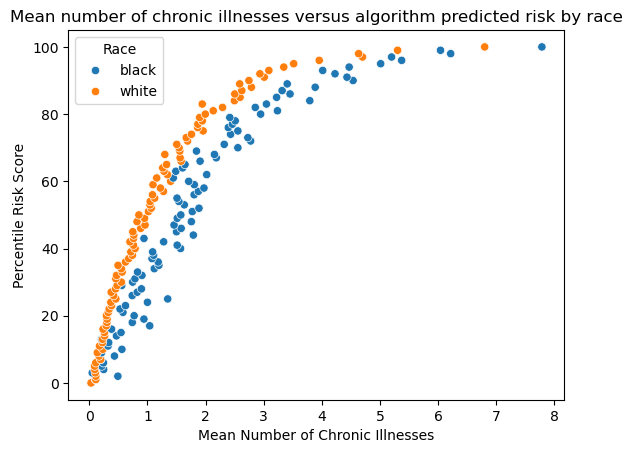

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

df_imp['risk_percentile'] = round(df['risk_score_t'].rank(pct = True), 2) * 100

grouped_data = df_imp.groupby(['risk_percentile', 'race'])['gagne_sum_t'].mean()

grouped_data = pd.DataFrame(grouped_data)

sns.scatterplot(data=grouped_data, x='gagne_sum_t', y='risk_percentile', hue='race')

plt.xlabel('Mean Number of Chronic Illnesses')
plt.ylabel('Percentile Risk Score')
plt.title('Mean number of chronic illnesses versus algorithm predicted risk by race')

plt.legend(title='Race')
plt.show()

This plot begins to unravel some underlying racial bias that could be present in the algorithm. As seen in the figure, the orange dots representing white patients lie on a higher curve of percentile risk score. This suggests that less sick white patients are more likely to be referred to a high-risk program than sicker black patients.

(0.0, 80000.0)

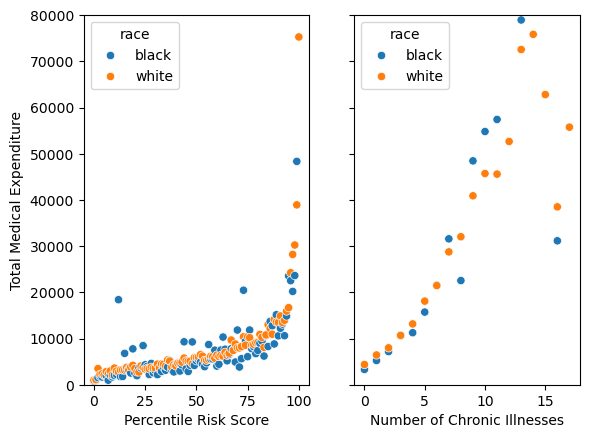

In [55]:
fig, axes = plt.subplots(1, 2, sharey = True)

grouped_cost_data = pd.DataFrame(df_imp.groupby(['risk_percentile', 'race'])['cost_t'].mean())
grouped_illness_data = pd.DataFrame(df_imp.groupby(['gagne_sum_t', 'race'])['cost_t'].mean())

sns.scatterplot(ax = axes[0], data=grouped_cost_data, x='risk_percentile', y='cost_t', hue='race')
sns.scatterplot(ax = axes[1], data=grouped_illness_data, x='gagne_sum_t', y='cost_t', hue='race')

axes[0].set_ylabel('Total Medical Expenditure')
axes[0].set_xlabel('Percentile Risk Score')
axes[1].set_xlabel('Number of Chronic Illnesses')

plt.ylim(0, 80000)


From this chart, we can see that holding either percentile risk score or number of chronic illnesses constant, black patients have lower costs than white patients. Further to the right on each graph, the amount of data available drops off steeply, which explains the more erratic correlation.

In [44]:
greater_than_5 = round((df_imp['gagne_sum_t'] >= 5).mean() * 100, 2)
greater_than_5

7.0

Given that 93% of the patients in this data set have 5 or less chronic conditions, it seems reasonable to focus on them, at least as a starting point. It is still important to analyze trends for patients with more chronic illnesses, but in the scope of this assignment, it could downplay trends, and without sufficient data, could display incorrect trends.

In [45]:
import numpy as np

df_not_0 = df_imp.drop(df_imp[df_imp['cost_t'] == 0].index)
df_not_0['log_cost'] = np.log(df_not_0['cost_t'])
df_not_0.head()

,risk_score_t,cost_t,race,gagne_sum_t,risk_percentile,log_cost
0,1.987430,1200.0,white,0,35.0,7.090077
1,7.677934,2600.0,white,3,86.0,7.863267
2,0.407678,500.0,white,0,4.0,6.214608
3,0.798369,1300.0,white,0,11.0,7.170120
4,17.513165,1100.0,white,1,98.0,7.003065


In [46]:
df_not_0 = pd.get_dummies(df_not_0)
df_not_0.head()

,risk_score_t,cost_t,gagne_sum_t,risk_percentile,log_cost,race_black,race_white
0,1.987430,1200.0,0,35.0,7.090077,0,1
1,7.677934,2600.0,3,86.0,7.863267,0,1
2,0.407678,500.0,0,4.0,6.214608,0,1
3,0.798369,1300.0,0,11.0,7.170120,0,1
4,17.513165,1100.0,1,98.0,7.003065,0,1


In [47]:
X_train = df_not_0[['gagne_sum_t', 'race_black']].rename(columns={'race_black' : 'race'})
y_train = df_not_0[['log_cost']]
X_train.head(10)

,gagne_sum_t,race
0,0,0
1,3,0
2,0,0
3,0,0
4,1,0
5,1,0
6,1,0
7,0,0
8,1,1
9,0,0


In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

LR = LinearRegression()
LR.fit(X_train, y_train)

def add_polynomial_features(X, degree):
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
  return X_

In [49]:
cv_scores = []

for i in range(1, 10):
    X_deg = add_polynomial_features(X_train, i)
    cv_scores.append(cross_val_score(LR.fit(X_deg, y_train), X_deg, y_train, cv=5).mean())

best_score = np.max(cv_scores)
best_deg = np.argmax(cv_scores)

print(cv_scores)
print(best_score)
print(best_deg)

[0.14538846793594323, 0.14538846793594318, 0.14700305368206446, 0.1469209985546572, 0.14733406563857981, 0.1477609417478441, 0.1480739986118528, 0.1481166054857896, 0.14820529981684197]
0.14820529981684197
8


In [56]:
best = add_polynomial_features(X_train, best_deg)

LR.fit(best, y_train)
w = LR.coef_
print(w)

[[ 3.36049611e-01 -2.66862126e-01  3.36049611e-01 -3.67776150e-01
   1.30350450e-01 -2.24509569e-02  1.99855281e-03 -8.86256261e-05
   1.54525291e-06]]


In [57]:
b_coef = w[0, 1]
b_coef

-0.26686212567281653

In [58]:
cost_incurred = np.exp(b_coef)
cost_incurred

0.7657786454027453

So, it looks like black patients, on average, pay about 3/4 of what white patients pay for health care. This is more or less following the argument of Obermeyer et al. (2019). I note that my percentage shows significantly larger disparity than what was found in the paper, but but show that black patients generate lower costs than white patients.

In this blog post, I found that preparing, processing, and cleaning data can take a lot of work to achieve the desired result. From the recreated figure 1, I found that on average, white patients are rated as having a higher risk score than black patients with the same amount of chronic illnesses. This puts black patients at risk because they are less likely to be referred to a high-risk program that can provide additional health care support. In figure 3, it was clear that, particularly for lower numbers of chronic illnesses (for which there was a lot more data), white patients typically spent more money than black patients. This was further emphasized by the analysis done of the performed linear regression, as described above. In my opinion, separation is the model of fairness that most clearly demonstrates the bias in this data set; the finding that sicker black patients don't qualify as frequently as less sick white patients suggests a higher false negative rate for black patients. This discrepancy in error rates leads to more black patients not receiving additional care, despite being qualified for it, and can lead to them falling through holes in the health care system without necessary support.